Local Linear Trend models are one of the simplest time series models, and can be expressed by the following equations:

$$ v_{t+1} \sim N\left(v_t, \sigma_v^2\right) $$

$$ x_t \sim N\left(x_{t-1} + v_{t-1}, \sigma_x^2\right) $$

$$ y_t \sim N\left(x_t, \sigma_y^2\right) $$

Where $\sigma_x^2$ is the observation error, $\sigma_y^2$ is the level disturbance, and $\sigma_v^2$ is the slope distrubance

We will model this in tensorflow-probability, using the air passengers dataset.

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

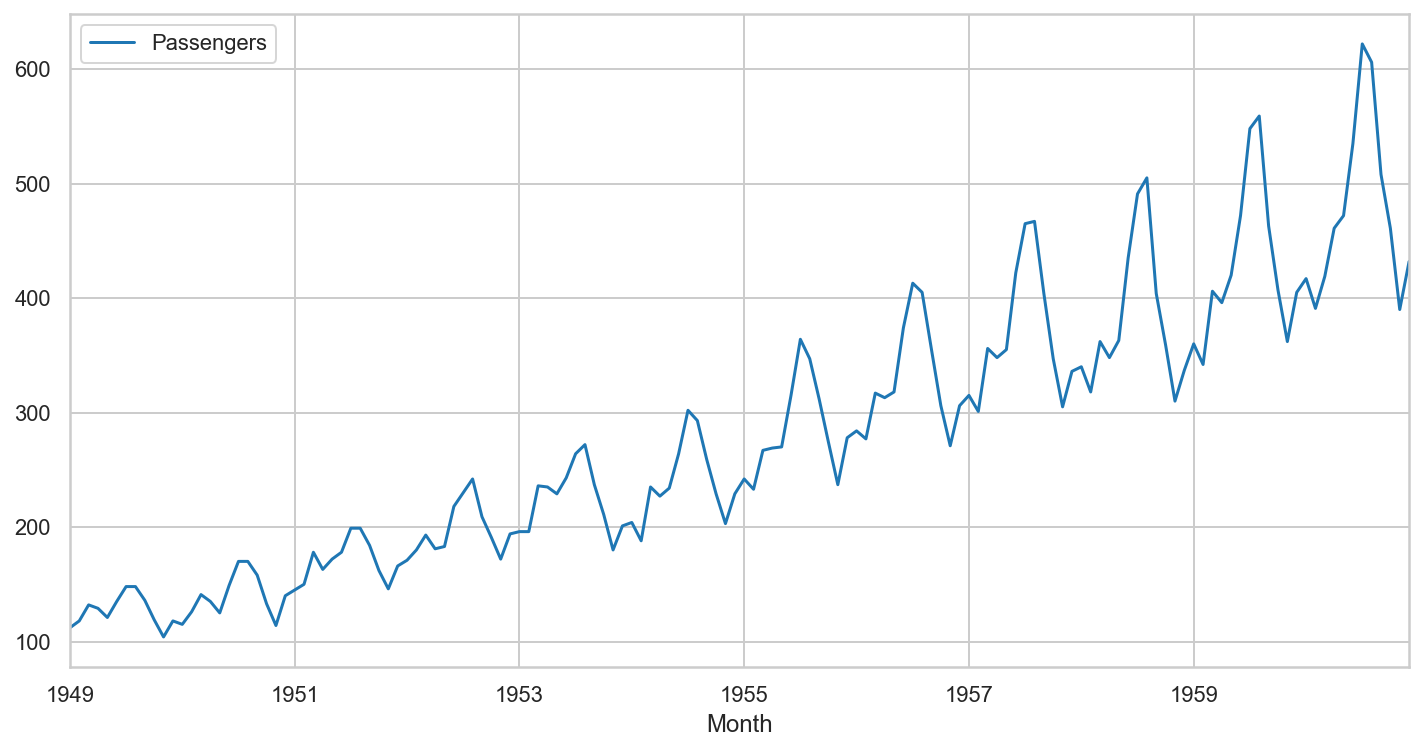

In [2]:
passengers = pd.read_csv('passengers.csv', header=0, sep=';')
passengers['Passengers'] = passengers['Passengers'].astype(float)
passengers['Month'] = pd.to_datetime(passengers['Month'])
passengers.set_index('Month', inplace=True)
passengers.plot(figsize=(12, 6))

In [3]:
train_df = passengers.loc[:'1959-01-01']

In [4]:
def build_model(observed_time_series):
    
    trend = tfp.sts.LocalLinearTrend(
        observed_time_series=observed_time_series
    )
    
    seasonal = tfp.sts.Seasonal(
        num_seasons=12, 
        observed_time_series=observed_time_series
    )
    
    model = sts.Sum(
        [trend, seasonal], 
        observed_time_series=observed_time_series
    )
    return model

In [5]:
model = build_model(train_df['Passengers'])

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)

Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.


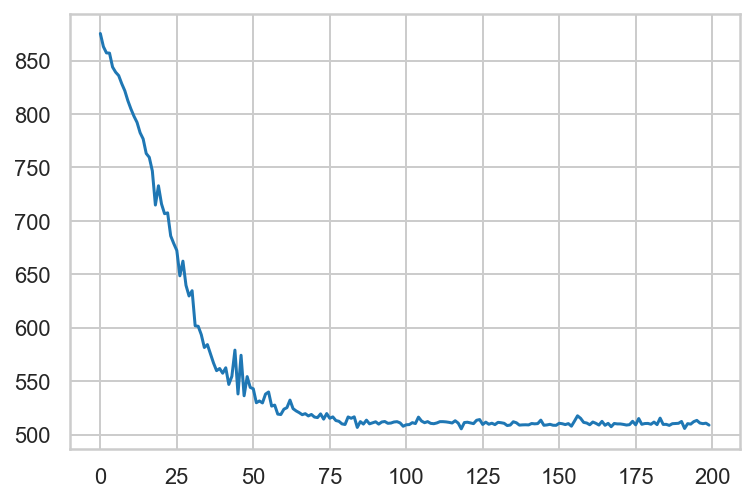

In [6]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function()
def train():
    
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_log_prob(
            observed_time_series=train_df['Passengers']
        ),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps
    )
    
    return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
samples = variational_posteriors.sample(50)

In [7]:
num_forecast_steps=24

forecast = tfp.sts.forecast(
    model,
    observed_time_series=train_df['Passengers'],
    parameter_samples=samples,
    num_steps_forecast=num_forecast_steps)


forecast_mean, forecast_scale, forecast_samples = (
    forecast.mean().numpy()[..., 0],
    forecast.stddev().numpy()[..., 0],
    forecast.sample(10).numpy()[..., 0])

In [8]:
# Original source https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb

def plot_forecast(data_df,
                  col_name,
                  forecast_start,
                  forecast_mean, 
                  forecast_scale, 
                  forecast_samples,
                  title, 
                  x_locator=None, 
                  x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    y = data_df[col_name]
    x = data_df.index

    num_steps = data_df.shape[0]
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast

    ax.plot(x, y, lw=2, color=c1, label='ground truth')

    forecast_steps = data_df.loc[forecast_start:].index

    ax.plot(forecast_steps, 
            forecast_samples.T, 
            lw=1, 
            color=c2, 
            alpha=0.1)

    ax.plot(forecast_steps, 
            forecast_mean, 
            lw=2, 
            ls='--', 
            color=c2,
            label='forecast')

    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, 
                   color=c2, 
                   alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.legend()
    return fig, ax

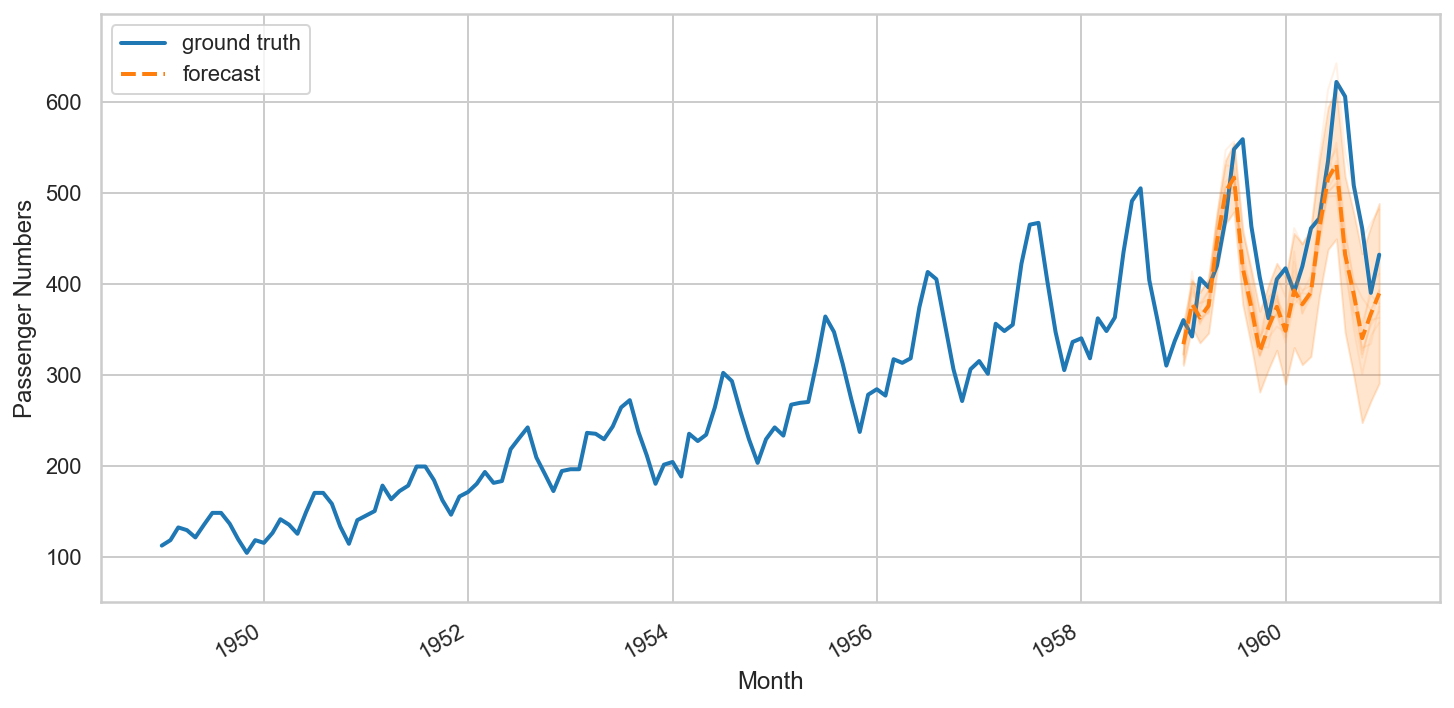

In [9]:
fig, ax = plot_forecast(
    passengers,
    'Passengers',
    '1959-01-01',
    forecast_mean, 
    forecast_scale, 
    forecast_samples,
    title='Airplane Passenger Numbers')
ax.legend(loc="upper left")
ax.set_ylabel("Passenger Numbers")
ax.set_xlabel("Month")
fig.autofmt_xdate()